In [24]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import Util
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ret, ret_nonan, univ, tradeidx, dates = Util.load_data()

In [7]:
FF = np.load('data/FF_5.npy')

In [2]:
df = pd.read_csv('data/FF_5.csv')
df.columns = ['Date'] + list(df.columns[1:])
df['Date'] = pd.to_datetime(df['Date'], format = "%Y%m%d")

In [3]:
df.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.00,-0.32,-0.01,0.15,0.012
1,1963-07-02,0.79,-0.27,0.27,-0.07,-0.19,0.012
2,1963-07-03,0.63,-0.17,-0.09,0.17,-0.33,0.012
3,1963-07-05,0.40,0.08,-0.28,0.08,-0.33,0.012
4,1963-07-08,-0.63,0.04,-0.18,-0.29,0.13,0.012


In [56]:
dates['Date'] = pd.to_datetime(dates[0])
dates['idx'] = dates.index

In [60]:
dates.head()

,0,Date,idx
0,1975-01-02,1975-01-02,0
1,1975-01-03,1975-01-03,1
2,1975-01-06,1975-01-06,2
3,1975-01-07,1975-01-07,3
4,1975-01-08,1975-01-08,4


In [70]:
facmat = []
for i, row in dates.iterrows():
    date = row['Date']
    ff = df[df.Date == date]
    assert(len(ff) == 1)
    vals = ff[ff.columns[1:-1]].values[0]
    facmat.append(vals)

In [73]:
facmat = np.array(facmat)
print(facmat.shape)

(10344, 5)


In [74]:
np.save('data/FF_5.npy', facmat)

In [8]:
pastRet = Util.get_past_period(5, 1260, 50, univ, tradeidx, ret)

In [9]:
fac_mat = Util.get_past_period_factor(5, 1260, tradeidx, FF)

In [12]:
#constructs residual matrix after getting betas for each asset
B = []
res_mat = []
for i in range(50):
    lm = LinearRegression()
    asset = pastRet[:, i]
    lm.fit(X = fac_mat, y = asset)
    beta_i = lm.coef_
    B.append(beta_i)
    pred = lm.predict(X = fac_mat)
    res = asset - pred
    res_mat.append(res)
res_mat = np.array(res_mat).T
B = np.array(B).T
print("Residual matrix shape: ", res_mat.shape)

Residual matrix shape:  (1260, 50)


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [21]:
S_u = np.cov(res_mat.T) #empirical covariance of residual matrix

In [22]:
S_f = np.cov(fac_mat.T) #empirical covariance of factors

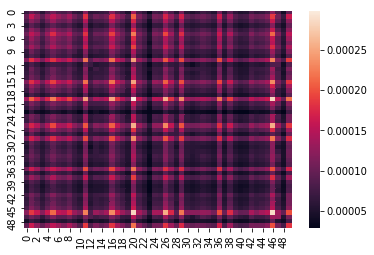

In [25]:
MTP2_component = B.T.dot(S_f).dot(B)
sns.heatmap(MTP2_component)
plt.show()

In [26]:
print("Proportion of entries that are negative in MTP2 component: ", np.sum(MTP2_component < 0)/MTP2_component.size)

Proportion of entries that are negative in MTP2 component:  0.0


Heatmap of S_f


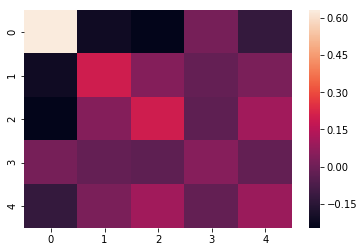

In [27]:
print("Heatmap of S_f")
sns.heatmap(S_f)
plt.show()

Heatmap of S_u


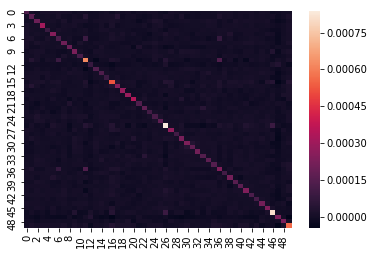

In [28]:
print("Heatmap of S_u")
sns.heatmap(S_u)
plt.show()

In [29]:
print("Proportion of entries that are negative in S_u: ", np.sum(S_u < 0)/S_u.size)

Proportion of entries that are negative in S_u:  0.4328


In [32]:
np.average(S_u[S_u < 0])

-6.782773928732819e-06